# **[Lab 9]** Optimizer Lab

In this lab, we will be covering common optimization algorithms used for training deep learning models.

Instead of Check-Offs, you'll just have Tasks! Do the tasks, and feel free to ask the TAs for help if you get stuck!

In [1]:
#@title <- Import Tensorflow and Numpy
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(" - Tensorflow :", tf.__version__)
print(" - Numpy      :", tf.__version__)
print(" - Pyplot     :", tf.__version__)

 - Tensorflow : 2.8.0
 - Numpy      : 2.8.0
 - Pyplot     : 2.8.0


## Optimizing the Rosenbrock function

In this lab, we will be testing our optimization algorithms on the [Rosenbrock function](https://en.wikipedia.org/wiki/Rosenbrock_function). 

$$
L_{RB}(\theta_0, \theta_1) = \big(a - \theta_1\big)^2 + b \times \big(\theta_2 - \theta_{\ 1}^{\ 2}\big)^2
$$

In our formulation: 
- $\theta$ is the parameters of the loss function, and would be the weights if we were training a neural network. These are the values that the optimizer is allowed to modify while minimizing the loss.
- $a$ and $b$ are constants that are specified for the loss function (AKA *loss hyperparameters*). 
  - You can assume default parameters $(a, b) = (1, 100)$

Run the following code to plot a contour plot of this function. The Rosenbrock function features a narrow valley, and has a minimum value at (1, 1), so you'll be trying to get an optimizer to optimize towards that minimum. 




In [2]:
# Define the function we will be optimizing in this lab
def rosenbrock(x, y, a=1, b=100):
    return (a - x)**2 + b * (y - x**2)**2

def plot_contour(visited_x, visited_y, loss_fn=rosenbrock, target=(1,1)):
    plt.clf()
    x_range = np.arange(-4, 4, .1)
    y_range = np.arange(-4, 6, .1)
    xx, yy = np.meshgrid(x_range, y_range)
    z = np.sqrt(loss_fn(xx, yy))
    plt.contourf(x_range, y_range, z, levels=100)
    plt.scatter(visited_x, visited_y, c='r')
    plt.scatter(target[:1], target[1:], c='y')
    plt.show()

def optimize(optimizer):
    parameters = tf.Variable([-3, -3], dtype=tf.float32)
    visited_x = [parameters[0].numpy()]
    visited_y = [parameters[1].numpy()]
    for i in range(1000):
        with tf.GradientTape() as tape:
            loss = rosenbrock(parameters[0], parameters[1])
        gradients = tape.gradient(loss, [parameters])[0]
        optimizer.apply_gradients([(gradients, parameters)])
        visited_x += [parameters[0].numpy()]
        visited_y += [parameters[1].numpy()]
    plot_contour(visited_x, visited_y)
    return parameters.numpy()


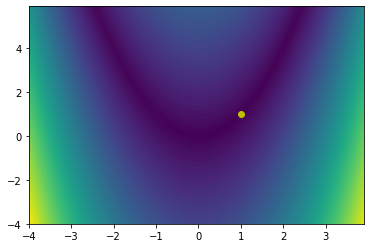

In [3]:
plot_contour([], [])

# (Stochastic) Gradient Descent

To train neural networks, we can change their parameters $\theta$ in a way to minimize a loss function. In order to decide what weight changes would best minimize the loss functoin, we calculate the gradient of the loss with respect to the parameters, which indicates the direction of steepest ascent.

Thus, we subtract the gradient scaled by some learning rate/scaling factor $\alpha$ and we arrive at the formula for gradient descent.

$$\theta_t = \theta_{t-1} - \alpha \nabla L(\theta_{t-1})$$

<br>

Though this formula might be very familiar, it does not represent specifically the procedure of Stochastic Gradient Descent, which is more accurate in describing the way deep networks are trained.

<br>

Standard "batch" gradient descent refers to evaluating the entire dataset and averaging the calculated gradients to update the weights. This is not used to train networks as not only is it very expensive to evaluate the gradient on the entire dataset for every iteration, this also generally leads the network to solutions that overfit and do not generalize.

Stochastic gradient descent is where random subsets, "mini-batches", of the training data are chosen to approximate the true gradient. Though it would increase stochasticity and decrease compute time to evaluate the gradient on single examples, the variance of gradient between single examples generally prevents the network from converging to neither quick nor effective solutions. Thus, the mini-batch size remains an important parameter that can make significant differences in the convergence, training time, or generalization of the network for non-trivial tasks.

## Task
Read the implementation below to see how to implement an optimizer. Notice that we are using  `parameters.assign` to update the parameters. 

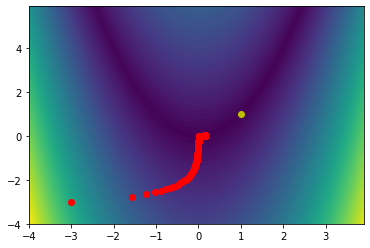

[0.15439285 0.02152821]


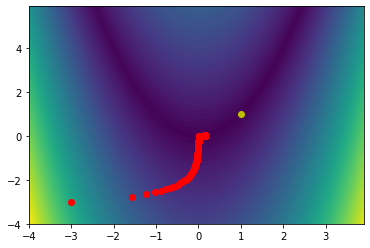

[0.15439285 0.02152821]


In [4]:
# Tensorflow implementation of SGD
print(optimize(tf.keras.optimizers.SGD(learning_rate=0.0001)))

# Your implementation of SGD
class SGD:
  def __init__(self, learning_rate):
    self.learning_rate = learning_rate
      
  def apply_gradients(self, grads_and_vars):
    gradients, parameters = grads_and_vars[0]
    parameters.assign(parameters - self.learning_rate * gradients)
    
print(optimize(SGD(0.0001)))

# Gradient Descent With Momentum

Gradient descent can easily find the valley of the Rosenbrock function, but since the magnitude of the gradient is so low along the valley, gradient descent gets stuck. 

With momentum, the parameters move by some fraction of the previous step along with the current gradient. This is similar to how a ball rolling down a hill will speed up over time. 


$$v_t = \lambda v_{t-1} + \alpha \nabla L(\theta)$$

$$\theta_t = \theta_{t-1} - v_t$$

An additional variable $v$ is used to keep track of the velocity. When $\lambda = 0$, it's as if the ball is rolling on a frictionless surface, since it will keep all of it's previous velocity. A typical value for $\lambda$ is $0.9$.

## Task
Implement gradient descent with momentum below. Check to see that your implementation matches the TensorFlow implementation.

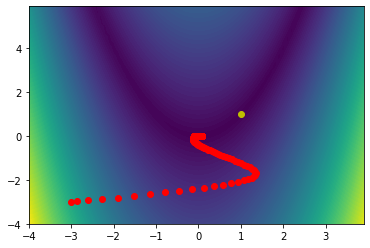

[0.08393675 0.00565818]


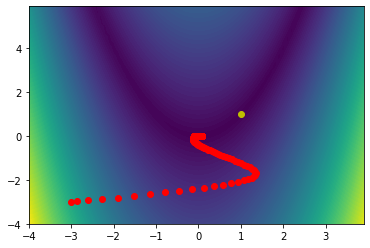

[0.08393682 0.00565819]


In [5]:
from numpy.lib.function_base import gradient
learning_rate = 0.00001
lambda_ = 0.9

# Tensorflow implementation of SGD with momentum
print(optimize(tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=lambda_)))


# Your implementation of SGD with momentum
class SGDMomentum:
  def __init__(self, learning_rate):
    self.learning_rate = learning_rate
    self.v = 0  # Zero vector for velocity
    self.lambda_ = lambda_
      
  def apply_gradients(self, grads_and_vars):
    gradients, parameters = grads_and_vars[0]
    
    # TODO: Implement
    self.v = self.lambda_ * self.v + self.learning_rate * gradients
    parameters.assign(parameters - self.v)
    
print(optimize(SGDMomentum(learning_rate=learning_rate)))

# Adagrad

For Adagrad, we keep a running total of the square of the gradients for each parameter. Denote this total for the $i$th parameter at timestep $t$ as $g_t^{(i)}$. The update step for $g$ is:

$$ g_t^{(i)} = g_{t-1}^{(i)} + \big(\frac{\partial }{\partial \theta^{(i)}}L(\theta_{t-1})\big)^2$$

Then, when updating the parameters, we divide the learning rate by $\sqrt{g_t} + \epsilon$. The $\epsilon$ is to prevent division by zero and a typical value is $10^{-7}$. Intuitively, this will cause the parameters move less in directions where the magnitude of the gradient is large, and to move more in the directions where the gradient is low. 

$$
\theta_t^{(i)} = \theta_{t-1}^{(i)} - \frac{\alpha}{\sqrt{g^{(i)}_t} + \epsilon} * \frac{\partial}{\partial\theta^{(i)}}  L(\theta_{t-1})
$$

Notice that the value of $g$ is positive and will monotonically increase over time. One problem that Adagrad faces is that the model's training will eventually stagnate as the learning rate goes to zero. 

## Task
Implement Adagrad below, and check to see that your implementation matches the Tensorflow implementation.

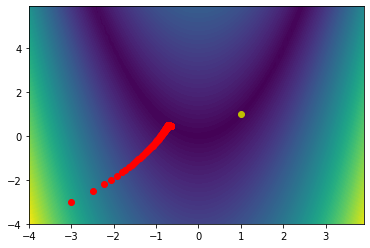

[-0.65694267  0.43507802]


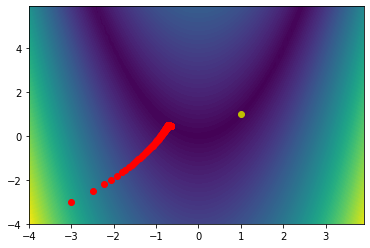

[-0.65694267  0.43507802]


In [6]:
print(optimize(tf.keras.optimizers.Adagrad(learning_rate=0.5)))

# Your implementation of Adagrad
class Adagrad:
  def __init__(self, learning_rate):
    self.learning_rate = learning_rate
    self.sum_squared_gradients = 0  # Zero vector
    self.epsilon = 1e-7
      
  def apply_gradients(self, grads_and_vars):
    gradients, parameters = grads_and_vars[0]
    
    ## TODO: Implement
    self.sum_squared_gradients = self.sum_squared_gradients + gradients**2
    parameters.assign(parameters - self.learning_rate/((self.sum_squared_gradients)**(1/2) + self.epsilon) * gradients) 
    
print(optimize(Adagrad(learning_rate=0.5)))

# RMSProp

RMSProp is similar to Adagrad, but seeks to solve the problem of the decaying learning rate. Instead of storing a sum of all of the past squared gradients, RMSprop keeps a exponentially decaying running average:

The running average is updated as follows:
$$ g_t^{(i)} =  \rho g_{t-1}^{(i)} + (1 - \rho)\Big(\frac{\partial}{\partial \theta^{(i)}}L(\theta_{t-1})\Big)^2 $$

Then, the parameter update is the same as for Adagrad. Dividing the learning rate by this exponential average will cause the learning to speed up in directions with lower gradients. This is what we want when navigating the valley of the Rosenbrock function. 

$$
\theta_t^{(i)} = \theta_{t-1}^{(i)} - \frac{\alpha}{\sqrt{g^{(i)}_t} + \epsilon} * \frac{\partial}{\partial\theta^{(i)}}L(\theta_{t-1})
$$

## Task
Implement RMSprop below, and check to see that your implementation matches the TensorFlow implementation:

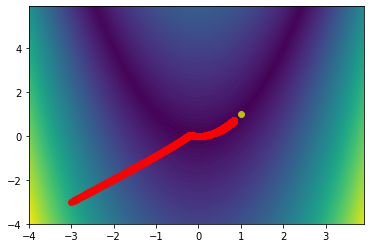

[0.8433816 0.6973202]


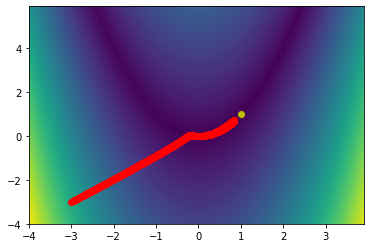

[0.8434404 0.6974192]


In [8]:
# Tensorflow implementation of RMSprop
print(optimize(tf.keras.optimizers.RMSprop(learning_rate=0.01)))

# Your implementation of RMS prop
class RMSprop:
  def __init__(self, learning_rate):
    self.learning_rate = learning_rate
    self.epsilon = 1e-7
    self.rho = 0.9  # Scaling factor for exponential average
    self.mean_square = 0  # Zero vector
      
  def apply_gradients(self, grads_and_vars):
    gradients, parameters = grads_and_vars[0]
    
    # TODO: Implement
    self.mean_square = self.rho * self.mean_square + (1 - self.rho)*((gradients)**2)
    parameters.assign(parameters - self.learning_rate/((self.mean_square)**(1/2) + self.epsilon) * gradients)
    
print(optimize(RMSprop(learning_rate=0.01)))


# Adam (Adaptive Moment Estimation) Optimizer

Adam is an iteration of previous algorithms which tries to estimate the first and second moments of the gradients.

The first moment is the expected value of the gradients, and the second moment is the expected value of the square of the gradients. Adam uses exponentially decaying averages to estimate these moments based on past gradients. $\beta_1$ and $\beta_2$ are the scaling factors for the exponential average, and the default values are $\beta_1=0.9$ and $\beta_2=0.999$.

$$m^{(i)}_t = \beta_1 m_{t-1} + (1 - \beta_1) \Big(\frac{\partial}{\partial \theta^{(i)}}L(\theta_{t-1})\Big)$$
$$v^{(i)}_t = \beta_2 v_{t-1} + (1 - \beta_2) \Big(\frac{\partial}{\partial \theta^{(i)}}L(\theta_{t-1})\Big)^2$$

However, these estimates are biased towards 0, so Adam scales them as follows:

$$\hat{m} = \frac{m}{1-\beta_1^t}$$

$$\hat{v} = \frac{v}{1-\beta_2^t}$$


The parameter update for Adam is then:

$$ \theta_t^{(i)} = \theta_{t-1}^{(i)} - \alpha * \frac{\hat{m}^{(i)}_t}{\sqrt{\hat{v}^{(i)}_t} + \epsilon} $$

Notice that the first moment is similar to the momentum in SGD with momentum, and the second moment is similar to the sum of squared gradients in RMSprop.

## Task:
Implement Adam below, and check to see that your implementation matches the TensorFlow implementation. Check off with your lab TA to make sure your implementations are correct.

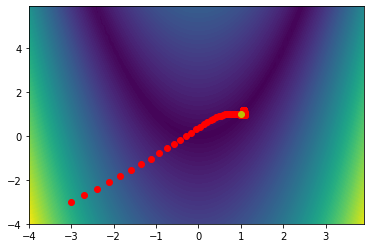

[1.0547324 1.1125813]


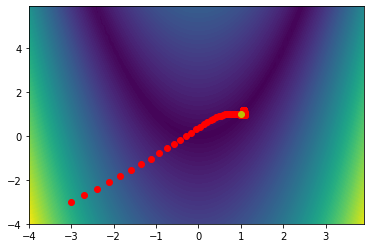

[1.0547329 1.112582 ]


In [12]:
print(optimize(tf.keras.optimizers.Adam(learning_rate=0.3)))

# Your implementation of Adam
class Adam:
  def __init__(self, learning_rate):
    self.learning_rate = learning_rate
    self.epsilon = 1e-7
    self.beta_1 = 0.9
    self.beta_2 = 0.999
    
    self.m = 0  # First moment zero vector
    self.v = 0  # Second moment zero vector.
    self.t = 0  # Time counter
      
  def apply_gradients(self, grads_and_vars):
    gradients, parameters = grads_and_vars[0]
    self.t += 1

    # TODO: Implement
    self.m = self.beta_1 * self.m + (1-self.beta_1)*gradients
    self.v = self.beta_2 * self.v + (1-self.beta_2)*(gradients**2)
    
    # TODO: Computer m_hat and v_hat
    m_hat = self.m / (1 - self.beta_1**self.t)
    v_hat = self.v / (1 - self.beta_2**self.t)
    parameters.assign(parameters - self.learning_rate * (m_hat/((v_hat**(1/2)) + self.epsilon)))
    
print(optimize(Adam(learning_rate=0.3)))


# Exploring the Landscape of Untrained Neural Networks

Since randomly initialized neural networks are essentially random functions, we can use this to our advantage to create a model landscape like the Rosenbrock Function with a more realistic high-dimensional loss landscapes. These better represent how gradient information must be more effectively used to traverse the loss landscape in the realistic timeframe of training a network.

<br>

Below, we've provided a 2 layer network that takes in 2 inputs like the Rosenbrock Function and has one output. Feel free to play around with what optimizer you choose, and how your parameters affect the pathway.


<br>

Keep in mind that even this more complicated landscape is very simple and smooth compared to the landscapes of training networks, since weights are initialized such that the weights and output of the network are small.


##Task: Have Fun!


The parameters we use as input are analagous to the parameters (ex. weights/biases) of networks that are trained with respect to some arbitrary loss function (in this case represented by the network). The problem of local minimas is quite apparent when comparing how far different optimizers are able to traverse parameter space with the same gradients. Check out how far SGD is able to descent the landscape compared to Adam!

In [13]:
class Landscape_Model(tf.keras.Model):

  def __init__(self,):
    """
    The model class inherits from tf.keras.Model.
    It stores the trainable weights as attributes.
    """
    super(Landscape_Model, self).__init__()
    
    self.W1 = tf.random.normal([2,64], stddev=0.1)
    self.b1 = tf.random.normal([64], stddev=0.1)
    self.W2 = tf.random.normal([64, 1], stddev=0.1)
    self.b2 = tf.random.normal([1], stddev=0.1, dtype=tf.float32)

  @tf.function
  def call(self, inputs):
    layer1Output = tf.nn.relu(tf.matmul(inputs, self.W1) + self.b1)
    score = tf.nn.sigmoid(tf.matmul(layer1Output, self.W2) + self.b2)
    
    return score

def plot_contour_model(visited_x, visited_y, model):
  plt.clf()
  x_range = np.arange(-10, 10, .1)
  y_range = np.arange(-10, 10, .1)
  xx, yy = np.meshgrid(x_range, y_range)
  xx = np.expand_dims(xx,axis=-1)
  yy = np.expand_dims(yy,axis=-1)
  input_coords = np.concatenate((xx,yy),axis=2)
  input_coords = tf.convert_to_tensor(input_coords, dtype='float32')
  score_grid = model(input_coords).numpy()
  score_grid = np.squeeze(score_grid)
  plt.contourf(x_range, y_range, score_grid, levels=200)
  plt.scatter(visited_x, visited_y, c='r')
  plt.scatter([-3], [-3], c='y')
  plt.show()

def optimize_model_landscape(optimizer, model):
  parameters = tf.Variable([[-3, -3]], dtype=tf.float32)
  visited_x = []
  visited_y = []
  for i in range(1000):
    with tf.GradientTape() as tape:
      loss = model(parameters)
      
    gradients = tape.gradient(loss, [parameters])[0]
    optimizer.apply_gradients([(gradients, parameters)])
    
    numpy_params = parameters.numpy()
    # print(numpy_params)
    visited_x.append(numpy_params[0,0])
    visited_y.append(numpy_params[0,1])
  plot_contour_model(visited_x, visited_y, model)
  return parameters.numpy()

from random import random
seed = random() #42

You can run the code below to see how the parameters change as the optimizer works, but this is not something we will be checking off.

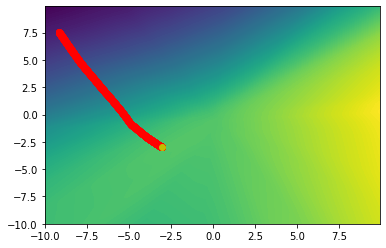

[[-9.151032  7.53685 ]]


In [19]:
tf.random.set_seed(seed) # Set the seed & initialize model each time to avoid errors
model = Landscape_Model()

optimizer = tf.keras.optimizers.SGD(learning_rate=0.5)
print(optimize_model_landscape(optimizer, model))

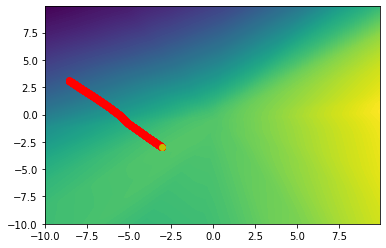

[[-8.563538   3.1170573]]


In [22]:
tf.random.set_seed(seed) # Set the seed & initialize model each time to avoid errors
model = Landscape_Model()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
print(optimize_model_landscape(optimizer, model))